In [ ]:
"""Notes:
1. Add more clusters (Use Categorical, not Bernoulli)
2. Add more dimensions
3. Group by genres, i.e. romance, scifi etc
4. Issue: there is a date inside the movieId that you have to remove!
5. Learn to compute the PPC

https://pyro.ai/examples/gmm.html
https://nbviewer.jupyter.org/github/Chinmay41018/mlppGMMClustering/blob/master/mlppGMMClustering.ipynb
"""

# Data 

In [ ]:
import os
import pandas as pd
import numpy as np

# The movies database
tmdb_path = os.path.join("../","data","the-movies-dataset")

ratings_dir = os.path.join(tmdb_path, "ratings.csv")
ratings_small_dir = os.path.join(tmdb_path, "ratings_small.csv")
movies_metadata_dir = os.path.join(tmdb_path, "movies_metadata.csv")
links_dir = os.path.join(tmdb_path, "links.csv")
links_small_dir = os.path.join(tmdb_path, "links_small.csv")
keywords_dir = os.path.join(tmdb_path, "keywords.csv")
credits_dir = os.path.join(tmdb_path, "credits.csv")

In [ ]:
# Ratings small
ratings_small = pd.read_csv(ratings_small_dir)
ratings_small

In [ ]:
# Movies metadata
movies_metadata = pd.read_csv(movies_metadata_dir)

# Transform the column from string to list of dict
movies_metadata['genres'] = movies_metadata['genres'].apply(lambda x: eval(x))

# Transform list of dict into list
movies_metadata['genres'] = movies_metadata['genres'].apply(lambda x: [genre['name'] for genre in x])

movies_metadata

In [ ]:
# Links
pd.read_csv(links_small_dir)

In [ ]:
pd.read_csv(keywords_dir)

In [ ]:
# 1. using the meta data
# 2. only focus on movies that are watched by a lot of the users, 
# 3. use pca or another dimensionality reduction method to make the # of features (movies) for each user less, then use GMM

In [ ]:
# 2. find the top K most rated movies

top_movieId = (ratings_small.groupby(['movieId'])
    .agg(['count'])['userId']['count']
    .sort_values(ascending=False)
)
top_movieId[:10]

In [ ]:
# 1. group by genres
import json

temp = movies_metadata[['id', 'genres']]

# MAGIC HERE!
# Create a movie genres table
# https://stackoverflow.com/questions/39954668/how-to-convert-column-with-list-of-values-into-rows-in-pandas-dataframe
movies_genres = (temp['genres']
    .apply(lambda x: pd.Series(x))
    .stack().reset_index(level=1, drop=True)
    .to_frame('genres')
    .join(temp[['id']], how='left')
)

# rename columns
movies_genres.columns = ['genres', 'movieId']

# reset index
movies_genres = movies_genres.reset_index(drop=True)

movies_genres


In [ ]:
# Select movies with Comedy only
movies_comedy_id = movies_genres[movies_genres['genres'] == 'Comedy']['movieId']
movies_comedy_id

In [ ]:
"""Issue: there is a date inside the movieId that you have to remove!"""
# Join genres and movie_ratings by id
#pd.merge(ratings_small, movies_genres, how='inner', on = 'movieId')
movies_genres['movieId']

# Example of PPC and POP-PC

In [1]:
import os
from collections import defaultdict
import numpy as np
import scipy.stats
import torch
import pandas as pd
from torch.distributions import constraints
from matplotlib import pyplot
%matplotlib inline

import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete

smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('0.4.1')
pyro.enable_validation(True)

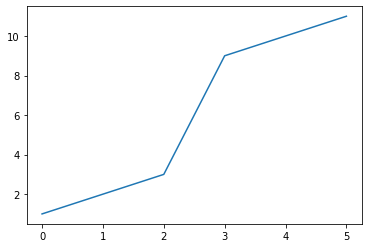

In [2]:
# Create toy dataset
data = torch.tensor([1., 2., 3., 9., 10., 11])
pyplot.plot(data)

In [3]:
K = 2  # Fixed number of components.

# = 1 dimension
@config_enumerate
def model(data):
    # Global variables.
    weights = pyro.sample('weights', dist.Dirichlet(0.5 * torch.ones(K)))
    scale = pyro.sample('scale', dist.LogNormal(0., 2.))
    with pyro.plate('components', K):
        locs = pyro.sample('locs', dist.Normal(0., 10.))

    with pyro.plate('data', len(data)):
        # Local variables.
        # Multinomial Dirichlet
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        pyro.sample('obs', dist.Normal(locs[assignment], scale), obs=data)

global_guide = AutoDelta(poutine.block(model, expose=['weights', 'locs', 'scale']))

In [4]:
optim = pyro.optim.Adam({'lr': 0.1, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)
svi = SVI(model, global_guide, optim, loss=elbo)

In [5]:
def initialize(seed):
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    # Initialize weights to uniform.
    pyro.param('auto_weights', 0.5 * torch.ones(K), constraint=constraints.simplex)
    # Assume half of the data variance is due to intra-component noise.
    pyro.param('auto_scale', (data.var() / 2).sqrt(), constraint=constraints.positive)
    # Initialize means from a subsample of data.
    pyro.param('auto_locs', data[torch.multinomial(torch.ones(len(data)) / len(data), K)]);
    loss = svi.loss(model, global_guide, data)
    return loss

# Choose the best among 100 random initializations.
loss, seed = min((initialize(seed), seed) for seed in range(100))
initialize(seed)
print('seed = {}, initial_loss = {}'.format(seed, loss))

seed = 5, initial_loss = 26.748218536376953


In [6]:
# Register hooks to monitor gradient norms.
gradient_norms = defaultdict(list)
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

losses = []
for i in range(200 if not smoke_test else 2):
    loss = svi.step(data)
    losses.append(loss)
    print('.' if i % 100 else '\n', end='')


...................................................................................................
...................................................................................................

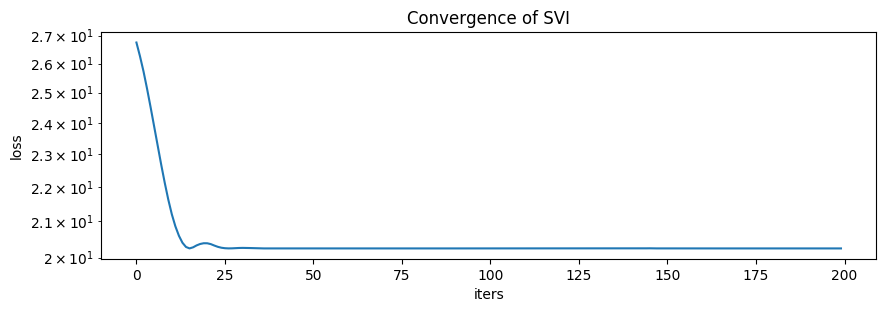

In [7]:
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(losses)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.yscale('log')
pyplot.title('Convergence of SVI');

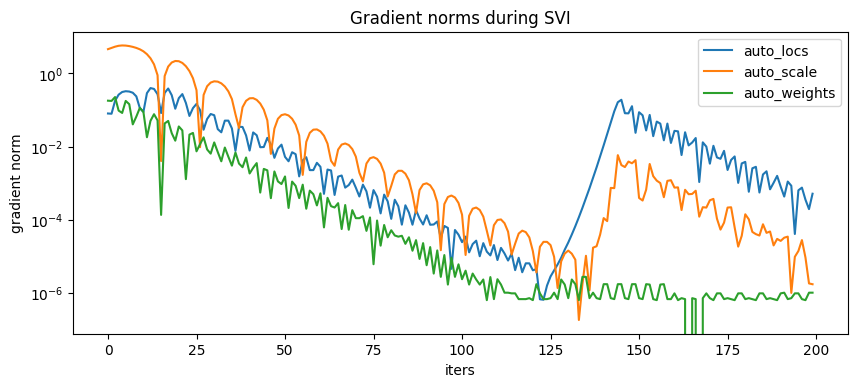

In [27]:
pyplot.figure(figsize=(10,4), dpi=100).set_facecolor('white')
for name, grad_norms in gradient_norms.items():
    pyplot.plot(grad_norms, label=name)
pyplot.xlabel('iters')
pyplot.ylabel('gradient norm')
pyplot.yscale('log')
pyplot.legend(loc='best')
pyplot.title('Gradient norms during SVI');

In [9]:
"""
the locs is the mean
the scale is the variance
weights of components of the GMMs, i.e. 0.5 0.5
"""
map_estimates = global_guide(data)
weights = map_estimates['weights']
locs = map_estimates['locs']
scale = map_estimates['scale']
print('weights = {}'.format(weights.data.numpy()))
print('locs = {}'.format(locs.data.numpy()))
print('scale = {}'.format(scale.data.numpy()))

weights = [0.50000006 0.49999994]
locs = [9.980795  1.9962474]
scale = 0.7597749829292297


The PPC is: tensor(1.1869, grad_fn=<AddBackward0>)


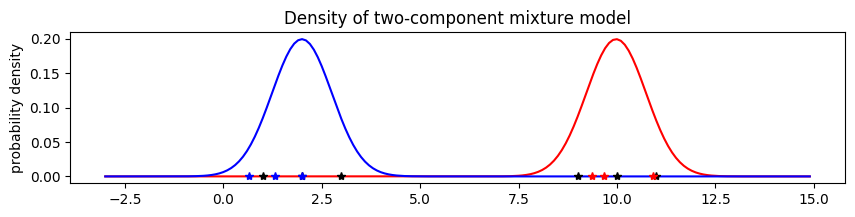

In [26]:
X = np.arange(-3,15,0.1)
Y1 = weights[0].item() * scipy.stats.norm.pdf((X - locs[0].item()) / scale.item())
Y2 = weights[1].item() * scipy.stats.norm.pdf((X - locs[1].item()) / scale.item())

# Compute PPC using MAP estimate
num_samples = 3

# Get replicated data
samples_1 = pyro.sample('sample_1', pyro.distributions.Normal(
    torch.ones(num_samples) * locs[0].item(), 
    torch.ones(num_samples) * scale.item())
) 

samples_2 = pyro.sample('sample_2', pyro.distributions.Normal(
    torch.ones(num_samples) * locs[1].item(), 
    torch.ones(num_samples) * scale.item())
) 

# Check visually
pyplot.figure(figsize=(10, 2), dpi=100).set_facecolor('white')
pyplot.plot(X, Y1, 'r-')
pyplot.plot(X, Y2, 'b-')
pyplot.plot(data.data.numpy(), np.zeros(len(data)), 'k*')
pyplot.plot(samples_1.numpy(), np.zeros(len(samples_1)), 'r*')
pyplot.plot(samples_2.numpy(), np.zeros(len(samples_2)), 'b*')
pyplot.title('Density of two-component mixture model')
pyplot.ylabel('probability density');

# Compute discrepancy function of replicated data
# simplest is empirical mean
samples_1_mean = torch.mean(samples_1)
samples_2_mean = torch.mean(samples_2)

# Observed data: this is hard coded
obs_1_mean = torch.mean(data[3:6])
obs_2_mean = torch.mean(data[:3])

# then compute the distance
# simplest is euclidean distance
distance_1 = torch.sqrt((samples_1_mean - obs_1_mean) ** 2)
distance_2 = torch.sqrt((samples_2_mean - obs_2_mean) ** 2)

# compute PPC which is expectation over distances
ppc = weights[0] * distance_1 + weights[1] + distance_2
print("The PPC is:", ppc)

In [28]:
# Compute POP-PC using cross validate
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_data, test_data = torch.utils.data.random_split(data, [train_size, test_size])

In [32]:
train_data = torch.tensor(train_data)
test_data = torch.tensor(test_data)

print(train_data)
print(test_data)

"""
RUN MODEL AGAIN
"""

# def initialize(seed):
#     pyro.set_rng_seed(seed)
#     pyro.clear_param_store()
#     # Initialize weights to uniform.
#     pyro.param('auto_weights', 0.5 * torch.ones(K), constraint=constraints.simplex)
#     # Assume half of the data variance is due to intra-component noise.
#     pyro.param('auto_scale', (train_data.var() / 2).sqrt(), constraint=constraints.positive)
#     # Initialize means from a subsample of data.
#     pyro.param('auto_locs', data[torch.multinomial(torch.ones(len(train_data)) / len(train_data), K)]);
#     loss = svi.loss(model, global_guide, train_data)
#     return loss

# # Choose the best among 100 random initializations.
# loss, seed = min((initialize(seed), seed) for seed in range(100))
# initialize(seed)
# print('seed = {}, initial_loss = {}'.format(seed, loss))

# # Register hooks to monitor gradient norms.
# gradient_norms = defaultdict(list)
# for name, value in pyro.get_param_store().named_parameters():
#     value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

losses = []
for i in range(200 if not smoke_test else 2):
    loss = svi.step(train_data)
    losses.append(loss)
    print('.' if i % 100 else '\n', end='')
    
map_estimates = global_guide(data)
weights = map_estimates['weights']
locs = map_estimates['locs']
scale = map_estimates['scale']
print('weights = {}'.format(weights.data.numpy()))
print('locs = {}'.format(locs.data.numpy()))
print('scale = {}'.format(scale.data.numpy()))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


tensor([ 1., 11., 10.,  3.])
tensor([2., 9.])

...................................................................................................
...................................................................................................weights = [0.49519637 0.5048036 ]
locs = [10.460568   1.9776901]
scale = 0.7042016386985779


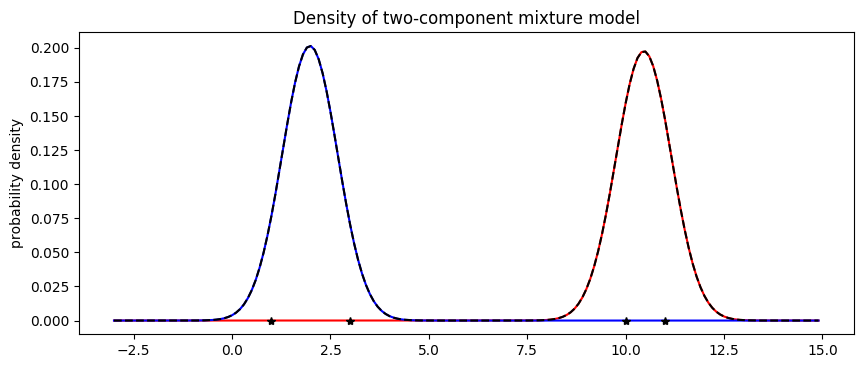

In [33]:
# Plot model using test data
X = np.arange(-3,15,0.1)
Y1 = weights[0].item() * scipy.stats.norm.pdf((X - locs[0].item()) / scale.item())
Y2 = weights[1].item() * scipy.stats.norm.pdf((X - locs[1].item()) / scale.item())

pyplot.figure(figsize=(10, 4), dpi=100).set_facecolor('white')
pyplot.plot(X, Y1, 'r-')
pyplot.plot(X, Y2, 'b-')
pyplot.plot(X, Y1 + Y2, 'k--')
pyplot.plot(train_data.data.numpy(), np.zeros(len(train_data)), 'k*')
pyplot.title('Density of two-component mixture model')
pyplot.ylabel('probability density');

In [42]:
# Get replicated data
num_samples = 2

samples_1 = pyro.sample('pop-pc_1', pyro.distributions.Normal(
    torch.ones(num_samples) * locs[0].item(), 
    torch.ones(num_samples) * scale.item())
) 

samples_2 = pyro.sample('pop-pc_2', pyro.distributions.Normal(
    torch.ones(num_samples) * locs[1].item(), 
    torch.ones(num_samples) * scale.item())
) 

# Compute discrepancy function of replicated data
# simplest is empirical mean
samples_1_mean = torch.mean(samples_1)
samples_2_mean = torch.mean(samples_2)

# New data
# Note: this is hard coded
new_1_mean = torch.mean(torch.ones(1)*9)
new_2_mean = torch.mean(torch.ones(1)*2)

# then compute the distance
# simplest is euclidean distance
distance_1 = torch.sqrt((samples_1_mean - new_1_mean) ** 2)
distance_2 = torch.sqrt((samples_2_mean - new_2_mean) ** 2)

# compute POP-PC which is expectation over distances
pop_pc = 0.50003326 * distance_1 + 0.49996674 + distance_2
print("The POP-PC is:", pop_pc)
print("Whereas the PPC is:", ppc)


The POP-PC is: tensor(2.4931)
Whereas the PPC is: tensor(1.1869, grad_fn=<AddBackward0>)


In [ ]:
# Get the posterior
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS
pyro.set_rng_seed(2)
kernel = NUTS(model)
mcmc = MCMC(kernel, num_samples=250, warmup_steps=50)
mcmc.run(data)
posterior_samples = mcmc.get_samples()

In [ ]:
#posterior_samples["locs"]
X, Y = posterior_samples["locs"].t()

In [ ]:
pyplot.figure(figsize=(8, 8), dpi=100).set_facecolor('white')
h, xs, ys, image = pyplot.hist2d(X.numpy(), Y.numpy(), bins=[20, 20])
pyplot.contour(np.log(h + 3).T, extent=[xs.min(), xs.max(), ys.min(), ys.max()],
               colors='white', alpha=0.8)
pyplot.title('Posterior density as estimated by collapsed NUTS')
pyplot.xlabel('loc of component 0')
pyplot.ylabel('loc of component 1')
pyplot.tight_layout()

In [ ]:
# https://stats.stackexchange.com/questions/174280/what-is-posterior-predictive-check-and-how-i-can-do-that-in-r
plot(posterior_samples["weights"])

# Method 2

In [ ]:
# Source: https://github.com/mcdickenson/em-gaussian/blob/master/em-gaussian-pyro.py
import matplotlib.pyplot as plt
import numpy as np
import pyro
import pyro.distributions as dist
import torch

from matplotlib.patches import Ellipse
from pyro import poutine
from pyro.contrib.autoguide import AutoDelta
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate
from torch.distributions import constraints

In [ ]:
@config_enumerate(default='parallel')
@poutine.broadcast
def model(data):
    # Global variables.
    """2 clusters"""
    #weights = pyro.param('weights', torch.FloatTensor([0.5]), constraint=constraints.unit_interval)
    #scales = pyro.param('scales', torch.tensor([[[1., 0.], [0., 2.]], [[3., 0.], [0., 4.]]]), constraint=constraints.positive)
    #locs = pyro.param('locs', torch.tensor([[1., 2.], [3., 4.]]))
    
    """3 clusters"""
    weights = pyro.param('weights', torch.FloatTensor([0.5]), constraint=constraints.unit_interval)
    scales = pyro.param('scales', torch.tensor([[[1., 0.], [0., 2.]], [[2., 0.], [0., 2.]], [[3., 0.], [0., 3.]]]), constraint=constraints.positive)
    locs = pyro.param('locs', torch.tensor([[0., 20.], [20., 0.], [10., 10.]]))

    with pyro.iarange('data', data.size(0)):
        # Local variables.
        assignment = pyro.sample('assignment', dist.Bernoulli(torch.ones(len(data)) * weights)).to(torch.int64)
        pyro.sample('obs', dist.MultivariateNormal(locs[assignment], scales[assignment]), obs=data)


@config_enumerate(default="parallel")
@poutine.broadcast
def full_guide(data):
    with pyro.iarange('data', data.size(0)):
        # Local variables.
        assignment_probs = pyro.param('assignment_probs', torch.ones(len(data)) / K,
                                      constraint=constraints.unit_interval)
        pyro.sample('assignment', dist.Bernoulli(assignment_probs), infer={"enumerate": "sequential"})

def initialize(data):
    pyro.clear_param_store()

    optim = pyro.optim.Adam({'lr': 0.1, 'betas': [0.8, 0.99]})
    elbo = TraceEnum_ELBO(max_iarange_nesting=1)
    svi = SVI(model, full_guide, optim, loss=elbo)

    # Initialize weights to uniform.
    pyro.param('auto_weights', 0.5 * torch.ones(K), constraint=constraints.simplex)

    # Assume half of the data variance is due to intra-component noise.
    var = (data.var() / 2).sqrt()
    pyro.param('auto_scale', torch.tensor([var]*4), constraint=constraints.positive)

    # Initialize means from a subsample of data.
    pyro.param('auto_locs', data[torch.multinomial(torch.ones(len(data)) / len(data), K)])

    loss = svi.loss(model, full_guide, data)

    return loss, svi

In [ ]:
def get_samples():
    num_samples = 100

    # 2 clusters
    # note that both covariance matrices are diagonal
    mu1 = torch.tensor([0., 20.])
    sig1 = torch.tensor([[2., 0.], [0., 3.]])

    mu2 = torch.tensor([20., 0.])
    sig2 = torch.tensor([[4., 0.], [0., 1.]])
    
    # add 3rd cluster
    mu3 = torch.tensor([10., 10.])
    sig3 = torch.tensor([[5., 0.], [0., 10.]])
    

    # generate samples
    dist1 = dist.MultivariateNormal(mu1, sig1)
    samples1 = [pyro.sample('samples1', dist1) for _ in range(num_samples)]

    dist2 = dist.MultivariateNormal(mu2, sig2)
    samples2 = [pyro.sample('samples2', dist2) for _ in range(num_samples)]
    
    dist3 = dist.MultivariateNormal(mu3, sig3)
    samples3 = [pyro.sample('samples2', dist3) for _ in range(num_samples)]

    data = torch.cat((torch.stack(samples1), torch.stack(samples2), torch.stack(samples3)))
    return data

In [ ]:
def plot(data, mus=None, sigmas=None, colors='black', figname='fig.png'):
    # Create figure
    fig = plt.figure()

    # Plot data
    x = data[:, 0]
    y = data[:, 1]
    plt.scatter(x, y, 24, c=colors)

    # Plot cluster centers
    if mus is not None:
        x = [float(m[0]) for m in mus]
        y = [float(m[1]) for m in mus]
        plt.scatter(x, y, 99, c='red')

    # Plot ellipses for each cluster
    if sigmas is not None:
        for sig_ix in range(K):
            ax = fig.gca()
            cov = np.array(sigmas[sig_ix])
            lam, v = np.linalg.eig(cov)
            lam = np.sqrt(lam)
            ell = Ellipse(xy=(x[sig_ix], y[sig_ix]),
                          width=lam[0]*4, height=lam[1]*4,
                          angle=np.rad2deg(np.arccos(v[0, 0])),
                          color='blue')
            ell.set_facecolor('none')
            ax.add_artist(ell)

    # Save figure
    fig.savefig(figname)

In [ ]:
if __name__ == "__main__":
    pyro.enable_validation(True)
    pyro.set_rng_seed(42)

    # Create our model with a fixed number of components
    K = 3

    data = get_samples()

    global_guide = AutoDelta(poutine.block(model, expose=['weights', 'locs', 'scales']))
    global_guide = config_enumerate(global_guide, 'parallel')
    _, svi = initialize(data)
    
    num_samples = 100
    true_colors = [0] * num_samples + [1] * num_samples + [2] * num_samples
    plot(data, colors=true_colors, figname='pyro_init.png')

    for i in range(151):
        svi.step(data)

        if i % 50 == 0:
            locs = pyro.param('locs')
            scales = pyro.param('scales')
            weights = pyro.param('weights')
            assignment_probs = pyro.param('assignment_probs')

            print("locs: {}".format(locs))
            print("scales: {}".format(scales))
            print('weights = {}'.format(weights))
            print('assignments: {}'.format(assignment_probs))

            # todo plot data and estimates
            assignments = np.uint8(np.round(assignment_probs.data))
            plot(data, locs.data, scales.data, assignments, figname='pyro_iteration{}.png'.format(i))